In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import backtrader as bt
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define Mean Reversion Strategy
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2),)

    def __init__(self):
        # Closing price from the data feed
        self.dataclose = self.datas[0].close

        # Simple Moving Average (SMA)
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)

        # Bollinger Bands Indicator
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.devfactor)

    def next(self):
        # Check if we are in the market (if we have an open position)
        if not self.position:
            # If the close price is below the lower Bollinger band, we consider it oversold -> Buy signal
            if self.dataclose[0] < self.bollinger.lines.bot:
                self.buy()  # Execute buy order
        else:
            # If the close price is above the upper Bollinger band, we consider it overbought -> Sell signal
            if self.dataclose[0] > self.bollinger.lines.top:
                self.sell()  # Execute sell order


# Function to load data from CSV
def load_data(file_path):
    # Load the data into a DataFrame, ensuring datetime column is properly parsed
    data = pd.read_csv(file_path, parse_dates=['datetime'])

    # Print the first few rows for verification
    print(f"Loading data from: {file_path}")
    print(data.head())

    # Rename columns to match the format expected by Backtrader
    data.rename(columns={
        'datetime': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)

    # Ensure 'Date' column is in datetime format and set it as the index
    data.set_index('Date', inplace=True)

    # Return only the relevant columns
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]


# Function to run the backtest
def run_backtest(data, cash=100000, commission=0.001):
    # Initialize backtrader's cerebro engine
    cerebro = bt.Cerebro()

    # Add data feed to cerebro
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)

    # Add the Mean Reversion strategy
    cerebro.addstrategy(MeanReversionStrategy)

    # Set initial cash and commission for the broker
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add performance analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print starting portfolio value
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run the backtest
    results = cerebro.run()

    # Print ending portfolio value
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Extract analyzers' results
    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    # Print Sharpe Ratio and maximum drawdown
    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()


# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Load the different time frame datasets using the correct file format
data_1h = load_data(os.path.join(folder_path, 'btcusdt_1h.csv'))
data_3m = load_data(os.path.join(folder_path, 'btcusdt_3m.csv'))
data_5m = load_data(os.path.join(folder_path, 'btcusdt_5m.csv'))
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))
data_30m = load_data(os.path.join(folder_path, 'btcusdt_30m.csv'))

# Run the backtest for one of the datasets (you can try with different time frames)
run_backtest(data_15m)  # Backtesting on 15-minute data


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_1h.csv
             datetime      open      high       low     close      volume
0 2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1 2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2 2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3 2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4 2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329
Loading data from: /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_3m.csv
             datetime      open      high       low     close     volume
0 2018-01-01 05:30:00  13715.65  13715.65  13666.11  13680.00   6.303815
1 2018-01-01 05:33:00  13679.98  13679.98  13554.44  13568.00  33.709206
2 2018-01-01 05:36:00  13568.00  13575.0

<IPython.core.display.Javascript object>

In [ ]:
import backtrader as bt
import pandas as pd
import os
from google.colab import drive
import numpy as np
from sklearn.preprocessing import StandardScaler

# Mount Google Drive
drive.mount('/content/drive')

# Define Heikin-Ashi Candlestick Conversion
def heikin_ashi(data):
    ha_data = data.copy()
    ha_data['HA_Close'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
    ha_data['HA_Open'] = (data['Open'].shift(1) + data['Close'].shift(1)) / 2
    ha_data['HA_High'] = data[['High', 'Open', 'Close']].max(axis=1)
    ha_data['HA_Low'] = data[['Low', 'Open', 'Close']].min(axis=1)
    return ha_data[['HA_Open', 'HA_High', 'HA_Low', 'HA_Close']]

# Define Mean Reversion Strategy with Indicators
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2),)

    def __init__(self):
        # Add Heikin-Ashi Candlesticks to the data
        self.heikin_ashi = heikin_ashi(self.datas[0].pandas_data)

        # Closing price from the data feed
        self.dataclose = self.datas[0].close

        # Indicators
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.devfactor)
        self.rsi = bt.indicators.RelativeStrengthIndex(self.datas[0], period=14)
        self.macd = bt.indicators.MACDHisto(self.datas[0])

    def next(self):
        if not self.position:  # If we do not have a position
            # If the close price is below the lower Bollinger band and RSI < 30 -> Buy signal
            if self.dataclose[0] < self.bollinger.lines.bot and self.rsi[0] < 30:
                self.buy()
        else:
            # If the close price is above the upper Bollinger band and RSI > 70 -> Sell signal
            if self.dataclose[0] > self.bollinger.lines.top and self.rsi[0] > 70:
                self.sell()

# Function to load and preprocess data from CSV
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['datetime'])

    # Convert to Heikin-Ashi Candlesticks
    ha_data = heikin_ashi(data)

    # Normalize the features (prices and volume)
    scaler = StandardScaler()
    data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

    # Return Heikin-Ashi Data
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Function to run the backtest
def run_backtest(data, cash=100000, commission=0.001):
    cerebro = bt.Cerebro()

    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)

    cerebro.addstrategy(MeanReversionStrategy)

    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add performance analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print initial portfolio value
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run the backtest
    results = cerebro.run()

    # Print ending portfolio value
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Extract analyzer results
    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    # Print Sharpe Ratio and Drawdown
    if 'sharperatio' in sharpe:
        print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    else:
        print("No Sharpe Ratio calculated")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()

# Load data and run backtest on different time frames
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))

# Run the backtest
run_backtest(data_15m)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: 'Open'

In [ ]:
import backtrader as bt
import pandas as pd
import os

# Define Mean Reversion Strategy with improvements
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2), ('atrperiod', 14), ('rsi_limit', 30))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.devfactor)
        self.atr = bt.indicators.AverageTrueRange(self.datas[0], period=self.params.atrperiod)
        self.rsi = bt.indicators.RelativeStrengthIndex(self.datas[0], period=self.params.atrperiod)
        self.stop_loss = None
        self.take_profit = None

    def next(self):
        if not self.position:
            # Buy if price is below lower Bollinger band and RSI is oversold
            if self.dataclose[0] < self.bollinger.lines.bot and self.rsi[0] < self.params.rsi_limit:
                self.buy(size=self.calculate_size())  # Buy with dynamic position size
                self.stop_loss = self.dataclose[0] - 2 * self.atr[0]
                self.take_profit = self.dataclose[0] + 3 * self.atr[0]  # Set take-profit

        else:
            # Exit if price hits upper Bollinger band or reaches take-profit/stop-loss
            if self.dataclose[0] > self.bollinger.lines.top or self.dataclose[0] >= self.take_profit:
                self.sell()  # Take profit
            elif self.dataclose[0] <= self.stop_loss:
                self.sell()  # Stop loss

    def calculate_size(self):
        """Dynamically calculates position size based on volatility (ATR)."""
        risk_per_trade = 0.02  # Risk 2% of portfolio per trade
        atr = self.atr[0]
        portfolio_value = self.broker.getvalue()
        size = (risk_per_trade * portfolio_value) / atr
        return size


# Function to load data from CSV with proper datetime parsing
def load_data(file_path):
    # Load the data into a DataFrame
    data = pd.read_csv(file_path, parse_dates=['Date'], infer_datetime_format=True)

    # Check if the date column exists, if not rename
    if 'Date' not in data.columns:
        data.columns = ['Date'] + list(data.columns[1:])  # Rename first column to 'Date'

    # Rename columns to match the expected format
    data.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)

    # Set the date column as the index
    data.set_index('Date', inplace=True)

    # Convert the index to datetime if not already
    data.index = pd.to_datetime(data.index)

    # Return only the relevant columns
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]



# Function to run the backtest
def run_backtest(data, cash=100000, commission=0.001):
    cerebro = bt.Cerebro()
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)
    cerebro.addstrategy(MeanReversionStrategy)
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())
    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()
    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")
    cerebro.plot()

# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Load the different time frame datasets
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))

# Run the backtest
run_backtest(data_15m)


<ipython-input-21-93f2ac3ebbf1>:45: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, parse_dates=['Date'], infer_datetime_format=True)


ValueError: Missing column provided to 'parse_dates': 'Date'

In [ ]:
# Import necessary libraries
import backtrader as bt
import pandas as pd
import os
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Mount Google Drive
drive.mount('/content/drive')

# Machine Learning Strategy
class MLStrategy(bt.Strategy):
    def __init__(self, model, scaler, features):
        self.model = model
        self.scaler = scaler
        self.features = features
        self.dataclose = self.datas[0].close

    def next(self):
        # Prepare the feature data
        row = pd.DataFrame({
            'open': [self.datas[0].open[0]],
            'high': [self.datas[0].high[0]],
            'low': [self.datas[0].low[0]],
            'close': [self.datas[0].close[0]],
            'volume': [self.datas[0].volume[0]],
        })

        # Scale the features
        row_scaled = self.scaler.transform(row[self.features])

        # Predict the market direction
        prediction = self.model.predict(row_scaled)

        # If we have no position, buy if prediction is positive, otherwise sell
        if not self.position:
            if prediction == 1:  # Buy signal
                self.buy()
        elif prediction == -1:  # Sell signal
            self.sell()

# Function to load data from CSV
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['datetime'])
    print(f"Loading data from: {file_path}")
    print(data.head())
    data.rename(columns={'datetime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    data.set_index('Date', inplace=True)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Function to prepare the machine learning model
def prepare_ml_model(data):
    # Create the target (1 for up, -1 for down)
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, -1)

    # Features and target
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    X = data[features]
    y = data['Target']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train_scaled, y_train)

    # Test the model
    predictions = model.predict(X_test_scaled)
    print(f"ML Model Accuracy: {accuracy_score(y_test, predictions)}")

    return model, scaler, features

# Function to run the backtest with ML strategy
def run_backtest_with_ml(data, cash=100000, commission=0.001):
    # Prepare ML model
    model, scaler, features = prepare_ml_model(data)

    # Initialize backtrader's cerebro engine
    cerebro = bt.Cerebro()

    # Add data feed to cerebro
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)

    # Add the ML strategy
    cerebro.addstrategy(MLStrategy, model=model, scaler=scaler, features=features)

    # Set initial cash and commission for the broker
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add performance analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print starting portfolio value
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run the backtest
    results = cerebro.run()

    # Print ending portfolio value
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Extract analyzers' results
    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    # Print Sharpe Ratio and maximum drawdown
    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()

# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Load the datasets
data_1h = load_data(os.path.join(folder_path, 'btcusdt_1h.csv'))
data_3m = load_data(os.path.join(folder_path, 'btcusdt_3m.csv'))
data_5m = load_data(os.path.join(folder_path, 'btcusdt_5m.csv'))
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))
data_30m = load_data(os.path.join(folder_path, 'btcusdt_30m.csv'))

# Run the backtest for different timeframes
print("Running backtest on 15-minute data:")
run_backtest_with_ml(data_15m)

print("Running backtest on 1-hour data:")
run_backtest_with_ml(data_1h)

print("Running backtest on 5-minute data:")
run_backtest_with_ml(data_5m)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_1h.csv
             datetime      open      high       low     close      volume
0 2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1 2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2 2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3 2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4 2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329
Loading data from: /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_3m.csv
             datetime      open      high       low     close     volume
0 2018-01-01 05:30:00  13715.65  13715.65  13666.11  13680.00   6.303815
1 2018-01-01 05:33:00  13679.98  13679.98  13554.44  13568.00  33.709206
2 2018-01-01 05:36:00  13568.00  13575.0

KeyError: "None of [Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')] are in the [columns]"

In [ ]:
# Import necessary libraries
import backtrader as bt
import pandas as pd
import os
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Mount Google Drive
drive.mount('/content/drive')

# Define Mean Reversion Strategy with Machine Learning Integration
class MLMeanReversionStrategy(bt.Strategy):
    def __init__(self, model):
        # Closing price from the data feed
        self.dataclose = self.datas[0].close

        # Track the machine learning model passed into the strategy
        self.model = model

    def next(self):
        # Prepare the feature vector for prediction (using basic indicators or price data)
        features = [
            self.datas[0].open[0],
            self.datas[0].high[0],
            self.datas[0].low[0],
            self.datas[0].close[0],
            self.datas[0].volume[0]
        ]

        # Make a prediction using the ML model
        prediction = self.model.predict([features])[0]

        # Execute buy or sell based on the model's prediction
        if prediction == 1 and not self.position:  # Buy signal
            self.buy()
        elif prediction == -1 and self.position:   # Sell signal
            self.sell()

# Function to load and preprocess data
def load_data(file_path):
    # Load the data into a DataFrame, ensuring datetime column is properly parsed
    data = pd.read_csv(file_path, parse_dates=['datetime'])

    # Print the first few rows for verification
    print(f"Loading data from: {file_path}")
    print(data.head())

    # Rename columns to match the format expected by Backtrader
    data.rename(columns={
        'datetime': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)

    # Ensure 'Date' column is in datetime format and set it as the index
    data.set_index('Date', inplace=True)

    # Return only the relevant columns
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Function to train an ML model on the data
def train_ml_model(data):
    # Prepare features and target for ML
    X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
    y = data['Close'].diff().apply(lambda x: 1 if x > 0 else -1).fillna(0).values  # Simple target

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"ML Model Accuracy: {accuracy}")

    return model

# Function to run the backtest with ML
def run_backtest_with_ml(data, cash=100000, commission=0.001):
    # Train ML model
    model = train_ml_model(data)

    # Initialize backtrader's cerebro engine
    cerebro = bt.Cerebro()

    # Add data feed to cerebro
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)

    # Add the ML-based strategy
    cerebro.addstrategy(MLMeanReversionStrategy, model=model)

    # Set initial cash and commission for the broker
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add performance analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print starting portfolio value
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run the backtest
    results = cerebro.run()

    # Print ending portfolio value
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Extract analyzers' results
    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    # Print Sharpe Ratio and maximum drawdown
    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()

# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Load the 1-hour interval data
data_1h = load_data(os.path.join(folder_path, 'btcusdt_1h.csv'))

# Run the backtest for the 1-hour interval data
print("Running backtest on 1-hour data:")
run_backtest_with_ml(data_1h)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_1h.csv
             datetime      open      high       low     close      volume
0 2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1 2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2 2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3 2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4 2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329
Running backtest on 1-hour data:
ML Model Accuracy: 0.8747514910536779
Starting Portfolio Value: 100000.00
Ending Portfolio Value: 6200.08
Sharpe Ratio: -1.1765381744592949
Max Drawdown: 94.49486935604139%


In [ ]:
# Import necessary libraries
import backtrader as bt
import pandas as pd
import os
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Mount Google Drive
drive.mount('/content/drive')

# Machine Learning Strategy
class MLStrategy(bt.Strategy):
    def __init__(self, model, scaler, features):
        self.model = model
        self.scaler = scaler
        self.features = features
        self.dataclose = self.datas[0].close

    def next(self):
        # Prepare the feature data
        row = pd.DataFrame({
            'open': [self.datas[0].open[0]],
            'high': [self.datas[0].high[0]],
            'low': [self.datas[0].low[0]],
            'close': [self.datas[0].close[0]],
            'volume': [self.datas[0].volume[0]],
        })

        # Scale the features
        row_scaled = self.scaler.transform(row[self.features])

        # Predict the market direction
        prediction = self.model.predict(row_scaled)

        # If we have no position, buy if prediction is positive, otherwise sell
        if not self.position:
            if prediction == 1:  # Buy signal
                self.buy()
        elif prediction == -1:  # Sell signal
            self.sell()

# Function to load data from CSV
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['datetime'])
    data.rename(columns={'datetime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    data.set_index('Date', inplace=True)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Function to prepare the machine learning model by training on combined datasets
def prepare_ml_model(all_data):
    # Create the target (1 for up, -1 for down)
    all_data['Target'] = np.where(all_data['Close'].shift(-1) > all_data['Close'], 1, -1)

    # Features and target
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    X = all_data[features]
    y = all_data['Target']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest Classifier
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train_scaled, y_train)

    # Test the model
    predictions = model.predict(X_test_scaled)
    print(f"ML Model Accuracy: {accuracy_score(y_test, predictions)}")

    return model, scaler, features

# Function to run the backtest with ML strategy
def run_backtest_with_ml(backtest_data, model, scaler, features, cash=100000, commission=0.001):
    # Initialize backtrader's cerebro engine
    cerebro = bt.Cerebro()

    # Add data feed to cerebro
    data_feed = bt.feeds.PandasData(dataname=backtest_data)
    cerebro.adddata(data_feed)

    # Add the ML strategy
    cerebro.addstrategy(MLStrategy, model=model, scaler=scaler, features=features)

    # Set initial cash and commission for the broker
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add performance analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print starting portfolio value
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run the backtest
    results = cerebro.run()

    # Print ending portfolio value
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Extract analyzers' results
    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    # Print Sharpe Ratio and maximum drawdown
    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()

# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Load the datasets
data_1h = load_data(os.path.join(folder_path, 'btcusdt_1h.csv'))
data_3m = load_data(os.path.join(folder_path, 'btcusdt_3m.csv'))
data_5m = load_data(os.path.join(folder_path, 'btcusdt_5m.csv'))
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))
data_30m = load_data(os.path.join(folder_path, 'btcusdt_30m.csv'))

# Combine all datasets for model training
all_data = pd.concat([data_1h, data_3m, data_5m, data_15m, data_30m]).dropna()

# Prepare the ML model using the combined data
model, scaler, features = prepare_ml_model(all_data)

# Run the backtest on 1-hour interval data
print("Running backtest on 1-hour data:")
run_backtest_with_ml(data_1h, model, scaler, features)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ML Model Accuracy: 0.5209942920004226
Running backtest on 1-hour data:
Starting Portfolio Value: 100000.00


KeyError: "None of [Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')] are in the [columns]"

In [ ]:
import backtrader as bt
import pandas as pd
import os
from google.colab import drive
from scipy.optimize import minimize

# Mount Google Drive
drive.mount('/content/drive')

# Define Mean Reversion Strategy with optimized parameters
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2), ('atr_period', 14), ('profit_target', 0.02), ('stop_loss', 0.01))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.devfactor)
        self.atr = bt.indicators.AverageTrueRange(self.datas[0], period=self.params.atr_period)

    def next(self):
        # Check if we are in the market (if we have an open position)
        if not self.position:
            # Filter out volatile periods using ATR
            if self.atr[0] < self.params.atr_period:
                # If the close price is below the lower Bollinger band, we consider it oversold -> Buy signal
                if self.dataclose[0] < self.bollinger.lines.bot:
                    self.buy()  # Execute buy order
        else:
            # Check for profit target and stop loss
            if self.position.size > 0:
                if self.dataclose[0] >= self.position.price * (1 + self.params.profit_target):
                    self.close()
                elif self.dataclose[0] <= self.position.price * (1 - self.params.stop_loss):
                    self.close()
            # If the close price is above the upper Bollinger band, we consider it overbought -> Sell signal
            if self.dataclose[0] > self.bollinger.lines.top:
                self.sell()  # Execute sell order

# Function to load data from CSV
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['datetime'])
    data.rename(columns={'datetime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    data.set_index('Date', inplace=True)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Function to run the backtest with optimization
def run_backtest_optimized(data, cash=100000, commission=0.001):
    def objective_function(params):
        # Unpack the parameters
        period, devfactor, atr_period, profit_target, stop_loss = params

        # Create a new Cerebro instance for optimization
        cerebro = bt.Cerebro()
        cerebro.adddata(bt.feeds.PandasData(dataname=data))

        # Add strategy with the passed parameters
        cerebro.addstrategy(MeanReversionStrategy, period=int(period), devfactor=devfactor, atr_period=int(atr_period),
                            profit_target=profit_target, stop_loss=stop_loss)

        # Set the broker parameters
        cerebro.broker.set_cash(cash)
        cerebro.broker.setcommission(commission=commission)

        # Add analyzer for Sharpe Ratio
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

        # Run the backtest
        result = cerebro.run()

        # Get the Sharpe Ratio
        sharpe_ratio = result[0].analyzers.sharpe.get_analysis().get('sharperatio', 0)

        # Negative sharpe because we are minimizing
        return -sharpe_ratio if sharpe_ratio is not None else float('inf')

    # Define initial parameter guess
    initial_guess = [20, 2, 14, 0.02, 0.01]

    # Define parameter bounds
    bounds = [(10, 50), (1, 5), (5, 30), (0.005, 0.05), (0.005, 0.05)]

    # Perform the optimization using scipy's minimize
    result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')

    # Extract the optimized parameters
    optimized_params = result.x
    print(f"Optimized Parameters: {optimized_params}")

    # Run final backtest with the optimized parameters
    cerebro = bt.Cerebro()
    cerebro.adddata(bt.feeds.PandasData(dataname=data))

    # Use optimized parameters in strategy
    cerebro.addstrategy(MeanReversionStrategy, period=int(optimized_params[0]), devfactor=optimized_params[1],
                        atr_period=int(optimized_params[2]), profit_target=optimized_params[3], stop_loss=optimized_params[4])

    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add analyzers for performance evaluation
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print the starting cash
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

    # Run the backtest
    results = cerebro.run()

    # Print the ending cash
    print(f"Ending Portfolio Value: {cerebro.broker.getvalue():.2f}")

    # Retrieve the Sharpe Ratio and Drawdown
    sharpe = results[0].analyzers.sharpe.get_analysis().get('sharperatio', 0)
    drawdown = results[0].analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', 0)

    print(f"Sharpe Ratio: {sharpe}")
    print(f"Max Drawdown: {drawdown}%")

    # Plot the final results
    cerebro.plot()

# Example usage:
# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))

# Run the optimized backtest
run_backtest_optimized(data_15m)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
!pip install backtrader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
import backtrader as bt
import pandas as pd
import os
from google.colab import drive
from scipy.optimize import minimize

# Mount Google Drive
drive.mount('/content/drive')

# Define Mean Reversion Strategy with optimized parameters
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2), ('atr_period', 14), ('profit_target', 0.02), ('stop_loss', 0.01))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=int(self.params.period))
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=int(self.params.period), devfactor=self.params.devfactor)
        self.atr = bt.indicators.AverageTrueRange(self.datas[0], period=int(self.params.atr_period))

    def next(self):
        # Check if we are in the market (if we have an open position)
        if not self.position:
            # Filter out volatile periods using ATR
            if self.atr[0] < self.params.atr_period:
                # If the close price is below the lower Bollinger band, we consider it oversold -> Buy signal
                if self.dataclose[0] < self.bollinger.lines.bot:
                    self.buy()  # Execute buy order
        else:
            # Check for profit target and stop loss
            if self.position.size > 0:
                if self.dataclose[0] >= self.position.price * (1 + self.params.profit_target):
                    self.close()
                elif self.dataclose[0] <= self.position.price * (1 - self.params.stop_loss):
                    self.close()
            # If the close price is above the upper Bollinger band, we consider it overbought -> Sell signal
            if self.dataclose[0] > self.bollinger.lines.top:
                self.sell()  # Execute sell order

# Function to load data from CSV
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['datetime'])
    data.rename(columns={'datetime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    data.set_index('Date', inplace=True)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Function to run the backtest with optimization
def run_backtest_optimized(data, cash=100000, commission=0.001):
    def objective_function(params):
        # Unpack the parameters
        period, devfactor, atr_period, profit_target, stop_loss = params

        # Create a new Cerebro instance for optimization
        cerebro = bt.Cerebro()
        cerebro.adddata(bt.feeds.PandasData(dataname=data))

        # Add strategy with the passed parameters
        cerebro.addstrategy(MeanReversionStrategy, period=int(period), devfactor=devfactor, atr_period=int(atr_period),
                            profit_target=profit_target, stop_loss=stop_loss)

        # Set the broker parameters
        cerebro.broker.set_cash(cash)
        cerebro.broker.setcommission(commission=commission)

        # Add analyzer for Sharpe Ratio
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

        # Run the backtest
        result = cerebro.run()

        # Get the Sharpe Ratio
        sharpe_ratio = result[0].analyzers.sharpe.get_analysis().get('sharperatio', 0)

        # Negative sharpe because we are minimizing
        return -sharpe_ratio if sharpe_ratio is not None else float('inf')

    # Define initial parameter guess
    initial_guess = [20, 2, 14, 0.02, 0.01]

    # Define parameter bounds
    bounds = [(10, 50), (1, 5), (5, 30), (0.005, 0.05), (0.005, 0.05)]

    # Perform the optimization using scipy's minimize
    result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')

    # Extract the optimized parameters
    optimized_params = result.x
    print(f"Optimized Parameters: {optimized_params}")

    # Run final backtest with the optimized parameters
    cerebro = bt.Cerebro()
    cerebro.adddata(bt.feeds.PandasData(dataname=data))

    # Use optimized parameters in strategy
    cerebro.addstrategy(MeanReversionStrategy, period=int(optimized_params[0]), devfactor=optimized_params[1],
                        atr_period=int(optimized_params[2]), profit_target=optimized_params[3], stop_loss=optimized_params[4])

    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add analyzers for performance evaluation
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print the starting cash
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

    # Run the backtest
    results = cerebro.run()

    # Print the ending cash
    print(f"Ending Portfolio Value: {cerebro.broker.getvalue():.2f}")

    # Retrieve the Sharpe Ratio and Drawdown
    sharpe = results[0].analyzers.sharpe.get_analysis().get('sharperatio', 0)
    drawdown = results[0].analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', 0)

    print(f"Sharpe Ratio: {sharpe}")
    print(f"Max Drawdown: {drawdown}%")

    # Plot the final results
    cerebro.plot()

# Example usage:
# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))

# Run the optimized backtest
run_backtest_optimized(data_15m)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import backtrader as bt
import pandas as pd
import numpy as np
import os
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

# Step 1: Define Heikin Ashi Denoiser Class
class HeikinAshiDenoiser:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.heikin_ashi_data = None

    def load_data(self):
        """
        Load BTC/USD data from a CSV file stored in Google Drive.
        """
        self.data = pd.read_csv(self.file_path, parse_dates=['datetime'], index_col='datetime')
        print(f"Data loaded: {len(self.data)} rows.")

    def calculate_heikin_ashi(self):
        """
        Calculate Heikin Ashi candles to denoise the price data.
        """
        self.heikin_ashi_data = pd.DataFrame(index=self.data.index)

        # Heikin Ashi close: (Open + High + Low + Close) / 4
        self.heikin_ashi_data['close'] = (self.data['open'] + self.data['high'] + self.data['low'] + self.data['close']) / 4

        # Initialize ha_open as a series filled with NaNs
        self.heikin_ashi_data['open'] = np.nan

        # Set the first value of ha_open to the average of open and close
        self.heikin_ashi_data.loc[self.heikin_ashi_data.index[0], 'open'] = (self.data['open'].iloc[0] + self.data['close'].iloc[0]) / 2

        # Fill the rest of ha_open using the previous ha_open and ha_close
        for i in range(1, len(self.heikin_ashi_data)):
            self.heikin_ashi_data.loc[self.heikin_ashi_data.index[i], 'open'] = (
                self.heikin_ashi_data.loc[self.heikin_ashi_data.index[i-1], 'open'] +
                self.heikin_ashi_data.loc[self.heikin_ashi_data.index[i-1], 'close']
            ) / 2

        # Heikin Ashi high: max(high, ha_open, ha_close)
        self.heikin_ashi_data['high'] = self.data[['high']].join(self.heikin_ashi_data[['open', 'close']]).max(axis=1)

        # Heikin Ashi low: min(low, ha_open, ha_close)
        self.heikin_ashi_data['low'] = self.data[['low']].join(self.heikin_ashi_data[['open', 'close']]).min(axis=1)

        # Heikin Ashi volume remains the same
        self.heikin_ashi_data['volume'] = self.data['volume']

        # Replace missing values with nearby values
        self.heikin_ashi_data = self.heikin_ashi_data.fillna(self.heikin_ashi_data.interpolate(method='nearest'))

    def get_heikin_ashi_data(self):
        return self.heikin_ashi_data

# Step 2: Define Mean Reversion Strategy Class
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2),)

    def __init__(self):
        # Closing price from the data feed
        self.dataclose = self.datas[0].close

        # Simple Moving Average (SMA)
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)

        # Bollinger Bands Indicator
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.devfactor)

    def next(self):
        # Check if we are in the market (if we have an open position)
        if not self.position:
            # If the close price is below the lower Bollinger band, we consider it oversold -> Buy signal
            if self.dataclose[0] < self.bollinger.lines.bot:
                self.buy()  # Execute buy order
        else:
            # If the close price is above the upper Bollinger band, we consider it overbought -> Sell signal
            if self.dataclose[0] > self.bollinger.lines.top:
                self.sell()  # Execute sell order


# Step 3: Function to run the backtest
def run_backtest(denoised_data, cash=100000, commission=0.001):
    # Initialize backtrader's cerebro engine
    cerebro = bt.Cerebro()

    # Add data feed to cerebro
    data_feed = bt.feeds.PandasData(dataname=denoised_data)
    cerebro.adddata(data_feed)

    # Add the Mean Reversion strategy
    cerebro.addstrategy(MeanReversionStrategy)

    # Set initial cash and commission for the broker
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add performance analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print starting portfolio value
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run the backtest
    results = cerebro.run()

    # Print ending portfolio value
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Extract analyzers' results
    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    # Print Sharpe Ratio and maximum drawdown
    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()

# Step 4: Main function to integrate Heikin Ashi denoising and backtesting
if __name__ == "__main__":
    # Google Drive folder path for the data
    folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

    # File path in Google Drive (replace this with the correct file)
    file_path = os.path.join(folder_path, "btcusdt_3m.csv")

    # Initialize Heikin Ashi Denoiser
    denoiser = HeikinAshiDenoiser(file_path)

    # Load and denoise the data using Heikin Ashi candles
    denoiser.load_data()
    denoiser.calculate_heikin_ashi()
    denoised_data = denoiser.get_heikin_ashi_data()

    # Run the backtest on the Heikin Ashi denoised data
    run_backtest(denoised_data)


Mounted at /content/drive
Data loaded: 703897 rows.
Starting Portfolio Value: 100000.00
Ending Portfolio Value: 3179.64
Sharpe Ratio: -0.5258210152382603
Max Drawdown: 96.83486128545734%


<IPython.core.display.Javascript object>

In [ ]:
!pip install backtrader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 25.7 MB/s eta 0:00:00


In [ ]:
import backtrader as bt
import pandas as pd
import numpy as np
from scipy import stats
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Step 1: Define utility functions for metrics
def calculate_sharpe_ratio(returns, risk_free_rate=0.07):
    excess_returns = np.array(returns) - risk_free_rate
    return excess_returns.mean() / excess_returns.std(ddof=1)


def calculate_sortino_ratio(returns, risk_free_rate=0.07, target_return=0):
    excess_returns = np.array(returns) - risk_free_rate
    downside_returns = excess_returns[excess_returns < target_return]
    if len(downside_returns) == 0:
        return np.inf  # No downside risk
    downside_std = np.std(downside_returns, ddof=1)
    if downside_std == 0:
        return np.inf  # To handle division by zero
    return (np.mean(excess_returns) - target_return) / downside_std

def calculate_max_drawdown(portfolio_values):
    peak = portfolio_values[0]
    max_drawdown = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

# Step 2: Define Mean Reversion Strategy with enhanced KPIs
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2),)

    def __init__(self):
        # Closing price from the data feed
        self.dataclose = self.datas[0].close

        # Simple Moving Average (SMA)
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)

        # Bollinger Bands Indicator
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.devfactor)

        # Track trades and performance metrics
        self.trades = []
        self.trade_returns = []
        self.trade_durations = []
        self.initial_value = self.broker.getvalue()

    def next(self):
        # Check if we are in the market (if we have an open position)
        if not self.position:
            # If the close price is below the lower Bollinger band, we consider it oversold -> Buy signal
            if self.dataclose[0] < self.bollinger.lines.bot:
                self.buy()  # Execute buy order
                self.entry_price = self.dataclose[0]
                self.entry_time = self.datetime.date(0)
        else:
            # If the close price is above the upper Bollinger band, we consider it overbought -> Sell signal
            if self.dataclose[0] > self.bollinger.lines.top:
                self.sell()  # Execute sell order
                trade_return = (self.dataclose[0] / self.entry_price - 1)
                self.trade_returns.append(trade_return)
                self.trades.append({
                    'entry_time': self.entry_time,
                    'exit_time': self.datetime.date(0),
                    'trade_return': trade_return
                })

    def stop(self):
        final_value = self.broker.getvalue()
        overall_return = (final_value / self.initial_value) - 1
        portfolio_values = [self.broker.getvalue() for i in range(len(self))]

        # Calculate key performance metrics
        sharpe_ratio = calculate_sharpe_ratio(self.trade_returns)
        sortino_ratio = calculate_sortino_ratio(self.trade_returns)
        max_drawdown = calculate_max_drawdown(portfolio_values)

        print(f"Final Portfolio Value: {final_value:.2f}")
        print(f"Overall Return: {overall_return:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Sortino Ratio: {sortino_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")

        # Print detailed trade metrics
        winning_trades = [t for t in self.trade_returns if t > 0]
        losing_trades = [t for t in self.trade_returns if t < 0]
        largest_winning_trade = max(winning_trades, default=0)
        largest_losing_trade = min(losing_trades, default=0)
        gross_profit = sum([t for t in self.trade_returns if t > 0])
        gross_loss = sum([t for t in self.trade_returns if t < 0])

        print(f"Total Trades: {len(self.trade_returns)}")
        print(f"Winning Trades: {len(winning_trades)}")
        print(f"Losing Trades: {len(losing_trades)}")
        print(f"Largest Winning Trade: {largest_winning_trade:.2%}")
        print(f"Largest Losing Trade: {largest_losing_trade:.2%}")
        print(f"Gross Profit: {gross_profit:.2%}")
        print(f"Gross Loss: {gross_loss:.2%}")
        print(f"Profit Factor: {gross_profit / abs(gross_loss):.2f}" if gross_loss != 0 else "Infinite")

        print("\nTrade-by-trade returns:")
        for i, trade in enumerate(self.trades):
            print(f"Trade {i+1}: Return: {trade['trade_return']:.2%}, Entry: {trade['entry_time']}, Exit: {trade['exit_time']}")


# Step 3: Function to load data from CSV
def load_data(file_path):
    # Load the data into a DataFrame, ensuring datetime column is properly parsed
    data = pd.read_csv(file_path, parse_dates=['datetime'])

    # Print the first few rows for verification
    print(f"Loading data from: {file_path}")
    print(data.head())

    # Rename columns to match the format expected by Backtrader
    data.rename(columns={
        'datetime': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)

    # Ensure 'Date' column is in datetime format and set it as the index
    data.set_index('Date', inplace=True)

    # Return only the relevant columns
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]


# Step 4: Function to run the backtest
def run_backtest(data, cash=100000, commission=0.001):
    # Initialize backtrader's cerebro engine
    cerebro = bt.Cerebro()

    # Add data feed to cerebro
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)

    # Add the Mean Reversion strategy
    cerebro.addstrategy(MeanReversionStrategy)

    # Set initial cash and commission for the broker
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add performance analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Print starting portfolio value
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run the backtest
    results = cerebro.run()

    # Print ending portfolio value
    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Extract analyzers' results
    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    # Print Sharpe Ratio and maximum drawdown
    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()


# Step 5: Main function
if __name__ == "__main__":
    # Set folder path to your Google Drive folder
    folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

    # Load the 15-minute dataset from Google Drive
    data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))

    # Run the backtest on the 15-minute data
    run_backtest(data_15m)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_15m.csv
             datetime      open      high       low     close      volume
0 2018-01-01 05:30:00  13715.65  13715.65  13400.01  13556.15  123.616013
1 2018-01-01 05:45:00  13533.75  13550.87  13402.00  13521.12   98.136430
2 2018-01-01 06:00:00  13500.00  13545.37  13450.00  13470.41   79.904037
3 2018-01-01 06:15:00  13494.65  13690.87  13450.00  13529.01  141.699719
4 2018-01-01 06:30:00  13528.99  13571.74  13402.28  13445.63   72.537533
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99059.77
Overall Return: -0.94%
Sharpe Ratio: -2.59
Sortino Ratio: -2.62
Max Drawdown: 0.00%
Total Trades: 1659
Winning Trades: 1154
Losing Trades: 505
Largest Winning Trade: 8.90%
Largest Losing Trade: -30.60%
Gross Profit: 1498.33%
Gross Loss: -1207.45%
Profit Factor: 1.24

Trade-

In [ ]:
import backtrader as bt
import pandas as pd
import numpy as np
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Step 1: Define utility functions for KPIs
def calculate_sharpe_ratio(returns, risk_free_rate=0.07):
    excess_returns = np.array(returns) - risk_free_rate
    return excess_returns.mean() / excess_returns.std(ddof=1)

def calculate_sortino_ratio(returns, risk_free_rate=0.07, target_return=0):
    excess_returns = np.array(returns) - risk_free_rate
    downside_returns = excess_returns[excess_returns < target_return]
    if len(downside_returns) == 0:
        return np.inf  # No downside risk
    downside_std = np.std(downside_returns, ddof=1)
    if downside_std == 0:
        return np.inf  # Handle division by zero
    return (np.mean(excess_returns) - target_return) / downside_std

def calculate_max_drawdown(portfolio_values):
    peak = portfolio_values[0]
    max_drawdown = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

# Step 2: Define the strategy
class EnhancedStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2),)

    def __init__(self):
        # Closing price from the data feed
        self.dataclose = self.datas[0].close

        # Simple Moving Average (SMA)
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)

        # Bollinger Bands Indicator
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.devfactor)

        # Track trades and performance metrics
        self.trades = []
        self.trade_returns = []
        self.initial_value = self.broker.getvalue()

    def next(self):
        # Check if we are in the market (if we have an open position)
        if not self.position:
            # Buy signal (oversold condition)
            if self.dataclose[0] < self.bollinger.lines.bot:
                self.buy()
                self.entry_price = self.dataclose[0]
                self.entry_time = self.datetime.date(0)
        else:
            # Sell signal (overbought condition)
            if self.dataclose[0] > self.bollinger.lines.top:
                self.sell()
                trade_return = (self.dataclose[0] / self.entry_price - 1)
                self.trade_returns.append(trade_return)

    def stop(self):
        final_value = self.broker.getvalue()
        overall_return = (final_value / self.initial_value) - 1
        portfolio_values = [self.broker.getvalue() for _ in range(len(self))]

        # Calculate key performance metrics
        sharpe_ratio = calculate_sharpe_ratio(self.trade_returns)
        sortino_ratio = calculate_sortino_ratio(self.trade_returns)
        max_drawdown = calculate_max_drawdown(portfolio_values)

        print(f"Final Portfolio Value: {final_value:.2f}")
        print(f"Overall Return: {overall_return:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Sortino Ratio: {sortino_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")

# Step 3: Function to load data
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['datetime'])
    print(f"Loading data from: {file_path}")
    data.rename(columns={'datetime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    data.set_index('Date', inplace=True)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Step 4: Backtest execution function
def run_backtest(data, cash=100000, commission=0.001):
    cerebro = bt.Cerebro()

    # Add data feed
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)

    # Add strategy
    cerebro.addstrategy(EnhancedStrategy)

    # Set broker cash and commission
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run backtest
    results = cerebro.run()

    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()

# Step 5: Main execution
if __name__ == "__main__":
    folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'
    data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))

    # Run the backtest
    run_backtest(data_15m)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_15m.csv
Starting Portfolio Value: 100000.00
Final Portfolio Value: 99059.77
Overall Return: -0.94%
Sharpe Ratio: -2.59
Sortino Ratio: -2.62
Max Drawdown: 0.00%
Ending Portfolio Value: 99059.77
Sharpe Ratio: -0.2853618727549735
Max Drawdown: 20.90720441951917%


In [ ]:
import backtrader as bt
import pandas as pd
import numpy as np
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Step 1: Define utility functions for KPIs
def calculate_sharpe_ratio(returns, risk_free_rate=0.07):
    excess_returns = np.array(returns) - risk_free_rate
    return excess_returns.mean() / excess_returns.std(ddof=1)

def calculate_sortino_ratio(returns, risk_free_rate=0.07, target_return=0):
    excess_returns = np.array(returns) - risk_free_rate
    downside_returns = excess_returns[excess_returns < target_return]
    if len(downside_returns) == 0:
        return np.inf  # No downside risk
    downside_std = np.std(downside_returns, ddof=1)
    if downside_std == 0:
        return np.inf  # Handle division by zero
    return (np.mean(excess_returns) - target_return) / downside_std

def calculate_max_drawdown(portfolio_values):
    peak = portfolio_values[0]
    max_drawdown = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

# Step 2: Define the enhanced strategy
class EnhancedStrategy(bt.Strategy):
    params = (('period', 20), ('devfactor', 2), ('rsi_lower', 30), ('rsi_upper', 70), ('atr_period', 14), ('trailing_stop_factor', 3))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        self.bollinger = bt.indicators.BollingerBands(self.datas[0], period=self.params.period, devfactor=self.params.devfactor)
        self.rsi = bt.indicators.RelativeStrengthIndex(self.datas[0])
        self.atr = bt.indicators.ATR(self.datas[0], period=self.params.atr_period)

        # Track trades and metrics
        self.trades = []
        self.trade_returns = []
        self.initial_value = self.broker.getvalue()

    def next(self):
        # Entry condition (RSI and Bollinger Band-based)
        if not self.position:
            if self.dataclose[0] < self.bollinger.lines.bot and self.rsi < self.params.rsi_lower:
                self.buy()
                self.entry_price = self.dataclose[0]
                self.trailing_stop = self.entry_price - (self.params.trailing_stop_factor * self.atr[0])

        # Exit condition (RSI, Bollinger Bands, or trailing stop)
        else:
            if self.dataclose[0] > self.bollinger.lines.top or self.rsi > self.params.rsi_upper or self.dataclose[0] < self.trailing_stop:
                self.sell()
                trade_return = (self.dataclose[0] / self.entry_price - 1)
                self.trade_returns.append(trade_return)

    def stop(self):
        final_value = self.broker.getvalue()
        overall_return = (final_value / self.initial_value) - 1
        portfolio_values = [self.broker.getvalue() for _ in range(len(self))]

        # Calculate key performance metrics
        sharpe_ratio = calculate_sharpe_ratio(self.trade_returns)
        sortino_ratio = calculate_sortino_ratio(self.trade_returns)
        max_drawdown = calculate_max_drawdown(portfolio_values)

        print(f"Final Portfolio Value: {final_value:.2f}")
        print(f"Overall Return: {overall_return:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Sortino Ratio: {sortino_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")

# Step 3: Function to load data
def load_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['datetime'])
    print(f"Loading data from: {file_path}")
    data.rename(columns={'datetime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    data.set_index('Date', inplace=True)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Step 4: Backtest execution function with optimization
def run_backtest(data, cash=100000, commission=0.001):
    cerebro = bt.Cerebro()

    # Add data feed
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)

    # Add strategy with optimization
    cerebro.optstrategy(EnhancedStrategy,
                        period=range(10, 40, 5),
                        devfactor=range(1, 3),
                        rsi_lower=range(25, 35, 5),
                        rsi_upper=range(65, 75, 5),
                        atr_period=range(10, 20, 5),
                        trailing_stop_factor=range(2, 4))

    # Set broker cash and commission
    cerebro.broker.set_cash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run backtest
    results = cerebro.run()

    print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

    sharpe = results[0].analyzers.sharpe.get_analysis()
    drawdown = results[0].analyzers.drawdown.get_analysis()

    print(f"Sharpe Ratio: {sharpe['sharperatio']}")
    print(f"Max Drawdown: {drawdown['max']['drawdown']}%")

    # Plot the results
    cerebro.plot()

# Step 5: Main execution
if __name__ == "__main__":
    folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'
    data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))

    # Run the backtest with optimization
    run_backtest(data_15m)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from: /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_15m.csv
Starting Portfolio Value: 100000.00
Final Portfolio Value: 97507.92
Overall Return: -2.49%
Sharpe Ratio: -2.75
Sortino Ratio: -3.49
Max Drawdown: 0.00%
Final Portfolio Value: 102602.67
Overall Return: 2.60%
Sharpe Ratio: -2.90
Sortino Ratio: -3.10
Max Drawdown: 0.00%
Final Portfolio Value: 95941.02
Overall Return: -4.06%
Sharpe Ratio: -2.78
Sortino Ratio: -3.51
Max Drawdown: 0.00%
Final Portfolio Value: 100146.98
Overall Return: 0.15%
Sharpe Ratio: -2.91
Sortino Ratio: -3.11
Max Drawdown: 0.00%
Final Portfolio Value: 97507.92
Overall Return: -2.49%
Sharpe Ratio: -2.75
Sortino Ratio: -3.49
Max Drawdown: 0.00%
Final Portfolio Value: 102602.67
Overall Return: 2.60%
Sharpe Ratio: -2.90
Sortino Ratio: -3.10
Max Drawdown: 0.00%
Final Portfolio Value: 95941.02
Overall Return: -4.06%

Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.10/dist-packages/backtrader/cerebro.py", line 1012, in __call__
    return self.runstrategies(iterstrat, predata=predata)
  File "/usr/local/lib/python3.10/dist-packages/backtrader/cere

KeyboardInterrupt: 

In [ ]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import pandas as pd
import numpy as np

# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Define function to load the CSV files
def load_data(file_path):
    return pd.read_csv(file_path, index_col='timestamp', parse_dates=True)

# Load all time frame datasets
data_1h = load_data(os.path.join(folder_path, 'btcusdt_1h.csv'))
data_3m = load_data(os.path.join(folder_path, 'btcusdt_3m.csv'))
data_5m = load_data(os.path.join(folder_path, 'btcusdt_5m.csv'))
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))
data_30m = load_data(os.path.join(folder_path, 'btcusdt_30m.csv'))

# Class definition for the BTCUSDT Strategy
class BTCUSDT_Strategy:
    def __init__(self, data, mode='conservative'):
        """
        Initializes the strategy with the market data and trading mode.
        :param data: DataFrame with OHLCV data.
        :param mode: 'conservative' or 'aggressive' - sets thresholds for signals.
        """
        self.data = data
        self.mode = mode
        self.signals = pd.DataFrame(index=self.data.index)
        self.signals['signal'] = 0  # Initialize signal column
        self.set_thresholds()  # Set thresholds based on trading mode

    def set_thresholds(self):
        """Set different thresholds based on conservative or aggressive mode."""
        if self.mode == 'conservative':
            self.mfi_lower = 40  # Conservative MFI threshold (was 35)
            self.rsi_lower = 40  # Conservative RSI threshold (was 35)
            self.mfi_upper = 60  # Conservative MFI upper for sell
            self.rsi_upper = 60  # Conservative RSI upper for sell
            self.dip_rise_buffer = 0.0015  # Low buffer to reduce drawdown
        elif self.mode == 'aggressive':
            self.mfi_lower = 30  # Aggressive MFI threshold (lower risk tolerance)
            self.rsi_lower = 30  # Aggressive RSI threshold
            self.mfi_upper = 70  # Aggressive MFI upper for sell
            self.rsi_upper = 70  # Aggressive RSI upper for sell
            self.dip_rise_buffer = 0.0025  # Higher buffer for higher risk

    def calculate_mfi(self, period=14):
        """Calculate the Money Flow Index (MFI)."""
        typical_price = (self.data['high'] + self.data['low'] + self.data['close']) / 3
        money_flow = typical_price * self.data['volume']
        self.data['positive_flow'] = money_flow.where(typical_price.diff() > 0, 0)
        self.data['negative_flow'] = money_flow.where(typical_price.diff() < 0, 0)
        rolling_positive_flow = self.data['positive_flow'].rolling(window=period).sum()
        rolling_negative_flow = self.data['negative_flow'].rolling(window=period).sum()
        self.data['mfi'] = 100 - (100 / (1 + (rolling_positive_flow / rolling_negative_flow)))

    def calculate_rsi(self, period=14):
        """Calculate the Relative Strength Index (RSI)."""
        delta = self.data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        self.data['rsi'] = 100 - (100 / (1 + rs))

    def calculate_macd(self):
        """Calculate the MACD."""
        self.data['ema12'] = self.data['close'].ewm(span=12, adjust=False).mean()
        self.data['ema26'] = self.data['close'].ewm(span=26, adjust=False).mean()
        self.data['macd'] = self.data['ema12'] - self.data['ema26']
        self.data['signal_line'] = self.data['macd'].ewm(span=9, adjust=False).mean()

    def calculate_stochastic(self, period=14):
        """Calculate the Stochastic Oscillator."""
        l14 = self.data['low'].rolling(window=period).min()
        h14 = self.data['high'].rolling(window=period).max()
        self.data['stoch_k'] = 100 * ((self.data['close'] - l14) / (h14 - l14))
        self.data['stoch_d'] = self.data['stoch_k'].rolling(window=3).mean()

    def detect_divergence(self, price, indicator, window=14):
        """Detect divergence between price and indicator."""
        price_change = price.diff(window)
        indicator_change = indicator.diff(window)
        bullish_div = (price_change < 0) & (indicator_change > 0)
        bearish_div = (price_change > 0) & (indicator_change < 0)
        return bullish_div, bearish_div

    def detect_crossover(self, series1, series2):
        """Detect crossover between two series."""
        crossover_up = (series1.shift(1) < series2.shift(1)) & (series1 > series2)
        crossover_down = (series1.shift(1) > series2.shift(1)) & (series1 < series2)
        return crossover_up, crossover_down

    def generate_signals(self):
        """Generate trading signals based on the strategy logic."""
        self.calculate_mfi()
        self.calculate_rsi()
        self.calculate_macd()
        self.calculate_stochastic()

        # Detect crossovers and divergences
        macd_crossover_up, macd_crossover_down = self.detect_crossover(self.data['macd'], self.data['signal_line'])
        stoch_crossover_up, stoch_crossover_down = self.detect_crossover(self.data['stoch_k'], self.data['stoch_d'])
        rsi_bull_div, rsi_bear_div = self.detect_divergence(self.data['close'], self.data['rsi'])
        macd_bull_div, macd_bear_div = self.detect_divergence(self.data['close'], self.data['macd'])

        current_signal = 0
        for i in range(1, len(self.data)):
            # Buy signal logic
            if ((self.data['mfi'].iloc[i] < self.mfi_lower) and (self.data['rsi'].iloc[i] < self.rsi_lower) and
                macd_crossover_up.iloc[i] and stoch_crossover_up.iloc[i]) or \
               ((rsi_bull_div.iloc[i] or macd_bull_div.iloc[i]) and (self.data['stoch_k'].iloc[i] < 25)):
                current_signal = 1  # Buy signal

            # Sell signal logic
            elif ((self.data['mfi'].iloc[i] > self.mfi_upper) and (self.data['rsi'].iloc[i] > self.rsi_upper) and
                  macd_crossover_down.iloc[i] and stoch_crossover_down.iloc[i]) or \
                 ((rsi_bear_div.iloc[i] or macd_bear_div.iloc[i]) and (self.data['stoch_k'].iloc[i] > 75)):
                current_signal = -1  # Sell signal

            # Potential dip during a buy
            elif current_signal == 1 and self.data['close'].iloc[i] < self.data['close'].iloc[i-1] * (1 - self.dip_rise_buffer):
                current_signal = 0  # Reset signal on dip

            # Potential rise during a sell
            elif current_signal == -1 and self.data['close'].iloc[i] > self.data['close'].iloc[i-1] * (1 + self.dip_rise_buffer):
                current_signal = 0  # Reset signal on rise

            self.signals.at[self.signals.index[i], 'signal'] = current_signal

    def backtest(self, initial_balance=100000):
        """Run a simple backtest and calculate returns, drawdown, and Sharpe ratio."""
        balance = initial_balance
        positions = 0  # Track positions
        returns = []
        max_balance = balance

        for i in range(1, len(self.data)):
            signal = self.signals['signal'].iloc[i]
            close_price = self.data['close'].iloc[i]

            # Buy logic
            if signal == 1 and positions == 0:
                positions = balance / close_price  # Buy with all available balance
                balance = 0

            # Sell logic
            elif signal == -1 and positions > 0:
                balance = positions * close_price  # Sell all positions
                positions = 0
                returns.append((balance - initial_balance) / initial_balance)

            # Calculate max drawdown
            max_balance = max(max_balance, balance + positions * close_price)
            drawdown = ((max_balance - (balance + positions * close_price)) / max_balance) * 100

        final_value = balance + positions * self.data['close'].iloc[-1]
        total_return = (final_value - initial_balance) / initial_balance
        annual_return = (1 + total_return) ** (365 / len(self.data)) - 1  # Approximation
        annual_volatility = np.std(returns) * np.sqrt(365)
        sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

        return {
            'final_value': final_value,
            'total_return': total_return * 100,
            'drawdown': drawdown,
            'sharpe_ratio': sharpe_ratio
        }

# Example usage
strategy_1h = BTCUSDT_Strategy(data_1h, mode='conservative')
strategy_1h.generate_signals()
backtest_results = strategy_1h.backtest()

print("Backtest Results (1h):", backtest_results)


Mounted at /content/drive


ValueError: 'timestamp' is not in list

In [ ]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import pandas as pd
import numpy as np

# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Define function to load the CSV files
def load_data(file_path):
    # Load the data into a DataFrame, ensuring the correct timestamp column is used
    data = pd.read_csv(file_path)
    print(f"Columns in {file_path}: {data.columns.tolist()}")  # Debug to check columns

    if 'timestamp' in data.columns:
        data.rename(columns={'timestamp': 'Date'}, inplace=True)
    elif 'datetime' in data.columns:
        data.rename(columns={'datetime': 'Date'}, inplace=True)
    else:
        raise ValueError("No timestamp or datetime column found")

    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Rename other columns to match Backtrader's format
    data.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)

    # Return the relevant columns for analysis
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Load all time frame datasets
data_1h = load_data(os.path.join(folder_path, 'btcusdt_1h.csv'))
data_3m = load_data(os.path.join(folder_path, 'btcusdt_3m.csv'))
data_5m = load_data(os.path.join(folder_path, 'btcusdt_5m.csv'))
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))
data_30m = load_data(os.path.join(folder_path, 'btcusdt_30m.csv'))

# Class definition for the BTCUSDT Strategy
class BTCUSDT_Strategy:
    def __init__(self, data, mode='conservative'):
        """
        Initializes the strategy with the market data and trading mode.
        :param data: DataFrame with OHLCV data.
        :param mode: 'conservative' or 'aggressive' - sets thresholds for signals.
        """
        self.data = data
        self.mode = mode
        self.signals = pd.DataFrame(index=self.data.index)
        self.signals['signal'] = 0  # Initialize signal column
        self.set_thresholds()  # Set thresholds based on trading mode

    def set_thresholds(self):
        """Set different thresholds based on conservative or aggressive mode."""
        if self.mode == 'conservative':
            self.mfi_lower = 40
            self.rsi_lower = 40
            self.mfi_upper = 60
            self.rsi_upper = 60
            self.dip_rise_buffer = 0.0015
        elif self.mode == 'aggressive':
            self.mfi_lower = 30
            self.rsi_lower = 30
            self.mfi_upper = 70
            self.rsi_upper = 70
            self.dip_rise_buffer = 0.0025

    def calculate_mfi(self, period=14):
        """Calculate the Money Flow Index (MFI)."""
        typical_price = (self.data['High'] + self.data['Low'] + self.data['Close']) / 3
        money_flow = typical_price * self.data['Volume']
        self.data['positive_flow'] = money_flow.where(typical_price.diff() > 0, 0)
        self.data['negative_flow'] = money_flow.where(typical_price.diff() < 0, 0)
        rolling_positive_flow = self.data['positive_flow'].rolling(window=period).sum()
        rolling_negative_flow = self.data['negative_flow'].rolling(window=period).sum()
        self.data['mfi'] = 100 - (100 / (1 + (rolling_positive_flow / rolling_negative_flow)))

    def calculate_rsi(self, period=14):
        """Calculate the Relative Strength Index (RSI)."""
        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        self.data['rsi'] = 100 - (100 / (1 + rs))

    def calculate_macd(self):
        """Calculate the MACD."""
        self.data['ema12'] = self.data['Close'].ewm(span=12, adjust=False).mean()
        self.data['ema26'] = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['macd'] = self.data['ema12'] - self.data['ema26']
        self.data['signal_line'] = self.data['macd'].ewm(span=9, adjust=False).mean()

    def calculate_stochastic(self, period=14):
        """Calculate the Stochastic Oscillator."""
        l14 = self.data['Low'].rolling(window=period).min()
        h14 = self.data['High'].rolling(window=period).max()
        self.data['stoch_k'] = 100 * ((self.data['Close'] - l14) / (h14 - l14))
        self.data['stoch_d'] = self.data['stoch_k'].rolling(window=3).mean()

    def detect_divergence(self, price, indicator, window=14):
        """Detect divergence between price and indicator."""
        price_change = price.diff(window)
        indicator_change = indicator.diff(window)
        bullish_div = (price_change < 0) & (indicator_change > 0)
        bearish_div = (price_change > 0) & (indicator_change < 0)
        return bullish_div, bearish_div

    def detect_crossover(self, series1, series2):
        """Detect crossover between two series."""
        crossover_up = (series1.shift(1) < series2.shift(1)) & (series1 > series2)
        crossover_down = (series1.shift(1) > series2.shift(1)) & (series1 < series2)
        return crossover_up, crossover_down

    def generate_signals(self):
        """Generate trading signals based on the strategy logic."""
        self.calculate_mfi()
        self.calculate_rsi()
        self.calculate_macd()
        self.calculate_stochastic()

        # Detect crossovers and divergences
        macd_crossover_up, macd_crossover_down = self.detect_crossover(self.data['macd'], self.data['signal_line'])
        stoch_crossover_up, stoch_crossover_down = self.detect_crossover(self.data['stoch_k'], self.data['stoch_d'])
        rsi_bull_div, rsi_bear_div = self.detect_divergence(self.data['Close'], self.data['rsi'])
        macd_bull_div, macd_bear_div = self.detect_divergence(self.data['Close'], self.data['macd'])

        current_signal = 0
        for i in range(1, len(self.data)):
            # Buy signal logic
            if ((self.data['mfi'].iloc[i] < self.mfi_lower) and (self.data['rsi'].iloc[i] < self.rsi_lower) and
                macd_crossover_up.iloc[i] and stoch_crossover_up.iloc[i]) or \
               ((rsi_bull_div.iloc[i] or macd_bull_div.iloc[i]) and (self.data['stoch_k'].iloc[i] < 25)):
                current_signal = 1  # Buy signal

            # Sell signal logic
            elif ((self.data['mfi'].iloc[i] > self.mfi_upper) and (self.data['rsi'].iloc[i] > self.rsi_upper) and
                  macd_crossover_down.iloc[i] and stoch_crossover_down.iloc[i]) or \
                 ((rsi_bear_div.iloc[i] or macd_bear_div.iloc[i]) and (self.data['stoch_k'].iloc[i] > 75)):
                current_signal = -1  # Sell signal

            # Potential dip during a buy
            elif current_signal == 1 and self.data['Close'].iloc[i] < self.data['Close'].iloc[i-1] * (1 - self.dip_rise_buffer):
                current_signal = 0  # Reset signal on dip

            # Potential rise during a sell
            elif current_signal == -1 and self.data['Close'].iloc[i] > self.data['Close'].iloc[i-1] * (1 + self.dip_rise_buffer):
                current_signal = 0  # Reset signal on rise

            self.signals.at[self.signals.index[i], 'signal'] = current_signal

    def backtest(self, initial_balance=100000):
        """Run a simple backtest and calculate returns, drawdown, and Sharpe ratio."""
        balance = initial_balance
        positions = 0  # Track positions
        returns = []
        max_balance = balance

        for i in range(1, len(self.data)):
            signal = self.signals['signal'].iloc[i]
            close_price = self.data['Close'].iloc[i]

            # Buy logic
            if signal == 1 and positions == 0:
                positions = balance / close_price  # Buy with all available balance
                balance = 0

            # Sell logic
            elif signal == -1 and positions > 0:
                balance = positions * close_price  # Sell all positions
                positions = 0
                returns.append((balance - initial_balance) / initial_balance)

            # Calculate max drawdown
            max_balance = max(max_balance, balance + positions * close_price)
            drawdown = ((max_balance - (balance + positions * close_price)) / max_balance) * 100

        final_value = balance + positions * self.data['Close'].iloc[-1]
        total_return = (final_value - initial_balance) / initial_balance
        annual_return = (1 + total_return) ** (365 / len(self.data)) - 1  # Approximation
        annual_volatility = np.std(returns) * np.sqrt(365)
        sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

        return {
            'final_value': final_value,
            'total_return': total_return * 100,
            'drawdown': drawdown,
            'sharpe_ratio': sharpe_ratio
        }

# Example usage
strategy_1h = BTCUSDT_Strategy(data_1h, mode='conservative')
strategy_1h.generate_signals()
backtest_results = strategy_1h.backtest()

print("Backtest Results (1h):", backtest_results)


Mounted at /content/drive
Columns in /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_1h.csv: ['datetime', 'open', 'high', 'low', 'close', 'volume']
Columns in /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_3m.csv: ['datetime', 'open', 'high', 'low', 'close', 'volume']
Columns in /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_5m.csv: ['datetime', 'open', 'high', 'low', 'close', 'volume']
Columns in /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_15m.csv: ['datetime', 'open', 'high', 'low', 'close', 'volume']
Columns in /content/drive/MyDrive/Quant Guild/mid_zelta/data/btcusdt_30m.csv: ['datetime', 'open', 'high', 'low', 'close', 'volume']
Backtest Results (1h): {'final_value': 96349.03631855655, 'total_return': -3.650963681443449, 'drawdown': 21.489995842444305, 'sharpe_ratio': -0.00011606442444827932}


In [ ]:
# Updated Backtester and Strategy for Better Sharpe Ratio

class BTCUSDT_Strategy:
    def __init__(self, data, mode='conservative'):
        """
        Initializes the strategy with the market data and trading mode.
        :param data: DataFrame with OHLCV data.
        :param mode: 'conservative' or 'aggressive' - sets thresholds for signals.
        """
        self.data = data
        self.mode = mode
        self.signals = pd.DataFrame(index=self.data.index)
        self.signals['signal'] = 0  # Initialize signal column
        self.set_thresholds()  # Set thresholds based on trading mode

    def set_thresholds(self):
        """Set different thresholds based on conservative or aggressive mode."""
        if self.mode == 'conservative':
            self.mfi_lower = 40
            self.rsi_lower = 40
            self.mfi_upper = 60
            self.rsi_upper = 60
            self.dip_rise_buffer = 0.0015
        elif self.mode == 'aggressive':
            self.mfi_lower = 30
            self.rsi_lower = 30
            self.mfi_upper = 70
            self.rsi_upper = 70
            self.dip_rise_buffer = 0.0025

    def calculate_mfi(self, period=14):
        """Calculate the Money Flow Index (MFI)."""
        typical_price = (self.data['High'] + self.data['Low'] + self.data['Close']) / 3
        money_flow = typical_price * self.data['Volume']
        self.data['positive_flow'] = money_flow.where(typical_price.diff() > 0, 0)
        self.data['negative_flow'] = money_flow.where(typical_price.diff() < 0, 0)
        rolling_positive_flow = self.data['positive_flow'].rolling(window=period).sum()
        rolling_negative_flow = self.data['negative_flow'].rolling(window=period).sum()
        self.data['mfi'] = 100 - (100 / (1 + (rolling_positive_flow / rolling_negative_flow)))

    def calculate_rsi(self, period=14):
        """Calculate the Relative Strength Index (RSI)."""
        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        self.data['rsi'] = 100 - (100 / (1 + rs))

    def calculate_macd(self):
        """Calculate the MACD."""
        self.data['ema12'] = self.data['Close'].ewm(span=12, adjust=False).mean()
        self.data['ema26'] = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['macd'] = self.data['ema12'] - self.data['ema26']
        self.data['signal_line'] = self.data['macd'].ewm(span=9, adjust=False).mean()

    def calculate_stochastic(self, period=14):
        """Calculate the Stochastic Oscillator."""
        l14 = self.data['Low'].rolling(window=period).min()
        h14 = self.data['High'].rolling(window=period).max()
        self.data['stoch_k'] = 100 * ((self.data['Close'] - l14) / (h14 - l14))
        self.data['stoch_d'] = self.data['stoch_k'].rolling(window=3).mean()

    def generate_signals(self):
        """Generate trading signals based on the strategy logic."""
        self.calculate_mfi()
        self.calculate_rsi()
        self.calculate_macd()
        self.calculate_stochastic()

        current_signal = 0
        position_size = 0  # Position size will vary based on risk management

        for i in range(1, len(self.data)):
            close_price = self.data['Close'].iloc[i]

            # Risk management - Stop-loss at 2%, take-profit at 3%
            stop_loss = 0.98 * self.data['Close'].iloc[i-1]
            take_profit = 1.03 * self.data['Close'].iloc[i-1]

            # Buy signal logic
            if ((self.data['mfi'].iloc[i] < self.mfi_lower) and
                (self.data['rsi'].iloc[i] < self.rsi_lower)):
                current_signal = 1  # Buy signal

                # Dynamic position sizing based on volatility
                position_size = 0.05 * close_price  # For example, 5% of the portfolio

            # Sell signal logic
            elif ((self.data['mfi'].iloc[i] > self.mfi_upper) and
                  (self.data['rsi'].iloc[i] > self.rsi_upper)):
                current_signal = -1  # Sell signal

            # Check for stop-loss or take-profit
            if current_signal == 1 and close_price <= stop_loss:
                current_signal = 0  # Exit buy if price drops to stop-loss
            elif current_signal == -1 and close_price >= take_profit:
                current_signal = 0  # Exit sell if price rises to take-profit

            self.signals.at[self.signals.index[i], 'signal'] = current_signal

    def backtest(self, initial_balance=100000):
        """Run a simple backtest and calculate returns, drawdown, and Sharpe ratio."""
        balance = initial_balance
        positions = 0  # Track positions
        returns = []
        max_balance = balance
        drawdown = 0

        for i in range(1, len(self.data)):
            signal = self.signals['signal'].iloc[i]
            close_price = self.data['Close'].iloc[i]

            # Buy logic
            if signal == 1 and positions == 0:
                positions = balance / close_price  # Buy with all available balance
                balance = 0

            # Sell logic
            elif signal == -1 and positions > 0:
                balance = positions * close_price  # Sell all positions
                positions = 0
                returns.append((balance - initial_balance) / initial_balance)

            # Track max drawdown
            max_balance = max(max_balance, balance + positions * close_price)
            drawdown = max(drawdown, ((max_balance - (balance + positions * close_price)) / max_balance) * 100)

        final_value = balance + positions * self.data['Close'].iloc[-1]
        total_return = (final_value - initial_balance) / initial_balance
        annual_return = (1 + total_return) ** (365 / len(self.data)) - 1  # Approximation
        annual_volatility = np.std(returns) * np.sqrt(365)
        sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

        return {
            'final_value': final_value,
            'total_return': total_return * 100,
            'drawdown': drawdown,
            'sharpe_ratio': sharpe_ratio
        }

# Example usage
strategy_1h = BTCUSDT_Strategy(data_1h, mode='conservative')
strategy_1h.generate_signals()
backtest_results = strategy_1h.backtest()

print("Backtest Results (1h):", backtest_results)


Backtest Results (1h): {'final_value': 38197.85241476863, 'total_return': -61.80214758523137, 'drawdown': 90.17707614596475, 'sharpe_ratio': -0.00355577270521102}


In [ ]:
import numpy as np
import pandas as pd

class BTCUSDT_Strategy:
    def __init__(self, data, mode='conservative'):
        """
        Initializes the strategy with the market data and trading mode.
        :param data: DataFrame with OHLCV data.
        :param mode: 'conservative' or 'aggressive' - sets thresholds for signals.
        """
        self.data = data
        self.mode = mode
        self.signals = pd.DataFrame(index=self.data.index)
        self.signals['signal'] = 0  # Initialize signal column
        self.set_thresholds()  # Set thresholds based on trading mode

    def set_thresholds(self):
        """Set different thresholds based on conservative or aggressive mode."""
        if self.mode == 'conservative':
            self.mfi_lower = 40
            self.rsi_lower = 40
            self.mfi_upper = 60
            self.rsi_upper = 60
            self.dip_rise_buffer = 0.0015
        elif self.mode == 'aggressive':
            self.mfi_lower = 30
            self.rsi_lower = 30
            self.mfi_upper = 70
            self.rsi_upper = 70
            self.dip_rise_buffer = 0.0025

    def calculate_mfi(self, period=14):
        """Calculate the Money Flow Index (MFI)."""
        typical_price = (self.data['High'] + self.data['Low'] + self.data['Close']) / 3
        money_flow = typical_price * self.data['Volume']
        self.data['positive_flow'] = money_flow.where(typical_price.diff() > 0, 0)
        self.data['negative_flow'] = money_flow.where(typical_price.diff() < 0, 0)
        rolling_positive_flow = self.data['positive_flow'].rolling(window=period).sum()
        rolling_negative_flow = self.data['negative_flow'].rolling(window=period).sum()
        self.data['mfi'] = 100 - (100 / (1 + (rolling_positive_flow / rolling_negative_flow)))

    def calculate_rsi(self, period=14):
        """Calculate the Relative Strength Index (RSI)."""
        delta = self.data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        self.data['rsi'] = 100 - (100 / (1 + rs))

    def calculate_macd(self):
        """Calculate the MACD."""
        self.data['ema12'] = self.data['Close'].ewm(span=12, adjust=False).mean()
        self.data['ema26'] = self.data['Close'].ewm(span=26, adjust=False).mean()
        self.data['macd'] = self.data['ema12'] - self.data['ema26']
        self.data['signal_line'] = self.data['macd'].ewm(span=9, adjust=False).mean()

    def calculate_stochastic(self, period=14):
        """Calculate the Stochastic Oscillator."""
        l14 = self.data['Low'].rolling(window=period).min()
        h14 = self.data['High'].rolling(window=period).max()
        self.data['stoch_k'] = 100 * ((self.data['Close'] - l14) / (h14 - l14))
        self.data['stoch_d'] = self.data['stoch_k'].rolling(window=3).mean()

    def generate_signals(self):
        """Generate trading signals based on the strategy logic."""
        self.calculate_mfi()
        self.calculate_rsi()
        self.calculate_macd()
        self.calculate_stochastic()

        current_signal = 0
        position_size = 0  # Position size will vary based on risk management

        for i in range(1, len(self.data)):
            close_price = self.data['Close'].iloc[i]

            # Risk management - Stop-loss at 2%, take-profit at 3%
            stop_loss = 0.98 * self.data['Close'].iloc[i-1]
            take_profit = 1.03 * self.data['Close'].iloc[i-1]

            # Buy signal logic
            if ((self.data['mfi'].iloc[i] < self.mfi_lower) and
                (self.data['rsi'].iloc[i] < self.rsi_lower)):
                current_signal = 1  # Buy signal

                # Dynamic position sizing based on volatility
                position_size = 0.05 * close_price  # For example, 5% of the portfolio

            # Sell signal logic
            elif ((self.data['mfi'].iloc[i] > self.mfi_upper) and
                  (self.data['rsi'].iloc[i] > self.rsi_upper)):
                current_signal = -1  # Sell signal

            # Check for stop-loss or take-profit
            if current_signal == 1 and close_price <= stop_loss:
                current_signal = 0  # Exit buy if price drops to stop-loss
            elif current_signal == -1 and close_price >= take_profit:
                current_signal = 0  # Exit sell if price rises to take-profit

            self.signals.at[self.signals.index[i], 'signal'] = current_signal

    def backtest(self, initial_balance=100000):
        """Run a backtest and calculate the requested metrics."""
        balance = initial_balance
        positions = 0
        total_closed_trades = 0
        winning_trades = 0
        losing_trades = 0
        gross_profit = 0
        gross_loss = 0
        max_drawdown = 0
        largest_winning_trade = 0
        largest_losing_trade = 0
        returns = []
        trade_durations = []
        max_balance = balance

        entry_time = None

        for i in range(1, len(self.data)):
            signal = self.signals['signal'].iloc[i]
            close_price = self.data['Close'].iloc[i]

            # Buy logic
            if signal == 1 and positions == 0:
                positions = balance / close_price  # Buy with all available balance
                balance = 0
                entry_time = self.data.index[i]  # Record entry time

            # Sell logic
            elif signal == -1 and positions > 0:
                exit_time = self.data.index[i]  # Record exit time
                trade_duration = (exit_time - entry_time).total_seconds() / 3600  # In hours
                trade_durations.append(trade_duration)

                balance = positions * close_price  # Sell all positions
                profit = balance - initial_balance
                positions = 0
                returns.append(profit / initial_balance)

                total_closed_trades += 1

                # Win/loss classification
                if profit > 0:
                    winning_trades += 1
                    gross_profit += profit
                    largest_winning_trade = max(largest_winning_trade, profit)
                else:
                    losing_trades += 1
                    gross_loss += profit  # Profit is negative here
                    largest_losing_trade = min(largest_losing_trade, profit)

                # Calculate max drawdown
                max_balance = max(max_balance, balance + positions * close_price)
                max_drawdown = max(max_drawdown, (max_balance - (balance + positions * close_price)) / max_balance * 100)

        final_value = balance + positions * self.data['Close'].iloc[-1]
        net_profit = gross_profit + gross_loss
        total_return = (final_value - initial_balance) / initial_balance
        win_rate = (winning_trades / total_closed_trades) * 100 if total_closed_trades else 0
        average_winning_trade = gross_profit / winning_trades if winning_trades else 0
        average_losing_trade = gross_loss / losing_trades if losing_trades else 0
        average_holding_duration = np.mean(trade_durations) if trade_durations else 0

        # Buy and Hold Return
        buy_and_hold_return = (self.data['Close'].iloc[-1] - self.data['Close'].iloc[0]) / self.data['Close'].iloc[0]

        # Calculate Sharpe Ratio
        annual_return = (1 + total_return) ** (365 / len(self.data)) - 1  # Approximation
        annual_volatility = np.std(returns) * np.sqrt(365)
        sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

        # Sortino Ratio (focuses on downside risk)
        downside_risk = np.std([r for r in returns if r < 0]) * np.sqrt(365)
        sortino_ratio = annual_return / downside_risk if downside_risk != 0 else np.nan

        return {
            'final_value': final_value,
            'net_profit': net_profit,
            'gross_profit': gross_profit,
            'gross_loss': gross_loss,
            'total_closed_trades': total_closed_trades,
            'win_rate': win_rate,
            'max_drawdown': max_drawdown,
            'largest_winning_trade': largest_winning_trade,
            'largest_losing_trade': largest_losing_trade,
            'average_winning_trade': average_winning_trade,
            'average_losing_trade': average_losing_trade,
            'buy_and_hold_return': buy_and_hold_return * 100,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'average_holding_duration': average_holding_duration
        }

# Example usage
strategy_1h = BTCUSDT_Strategy(data_1h, mode='conservative')
strategy_1h.generate_signals()
backtest_results = strategy_1h.backtest()

# Print all metrics
for key, value in backtest_results.items():
    print(f"{key}: {value}")


final_value: 38197.85241476863
net_profit: -39912613.15511668
gross_profit: 22358.15395661196
gross_loss: -39934971.30907329
total_closed_trades: 600
win_rate: 1.0
max_drawdown: 86.61584631074028
largest_winning_trade: 8066.500715892806
largest_losing_trade: -85536.21345757996
average_winning_trade: 3726.3589927686603
average_losing_trade: -67230.59142941632
buy_and_hold_return: 215.43328004044642
sharpe_ratio: -0.00355577270521102
sortino_ratio: -0.004042059810835738
average_holding_duration: 27.888333333333332


Mounted at /content/drive
1H Data Head: 
               datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1  2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2  2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3  2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4  2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329
3M Data Head: 
               datetime      open      high       low     close     volume
0  2018-01-01 05:30:00  13715.65  13715.65  13666.11  13680.00   6.303815
1  2018-01-01 05:33:00  13679.98  13679.98  13554.44  13568.00  33.709206
2  2018-01-01 05:36:00  13568.00  13575.00  13501.01  13575.00  29.645987
3  2018-01-01 05:39:00  13539.99  13575.00  13400.01  13515.26  30.696039
4  2018-01-01 05:42:00  13515.26  13568.66  13473.47  13556.15  23.260966


<ipython-input-1-59b44bdf242d>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-1-59b44bdf242d>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-1-59b44bdf242d>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-1-59b44bdf242d>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-1-59b44bdf242d>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() o

PCA Result (1H): 
 [[-0.62834461 -0.78614616]
 [-0.65531783 -0.81105805]
 [-0.66268725 -0.78963876]
 [-0.64938286 -0.79493374]
 [-0.64313698 -0.8318744 ]]


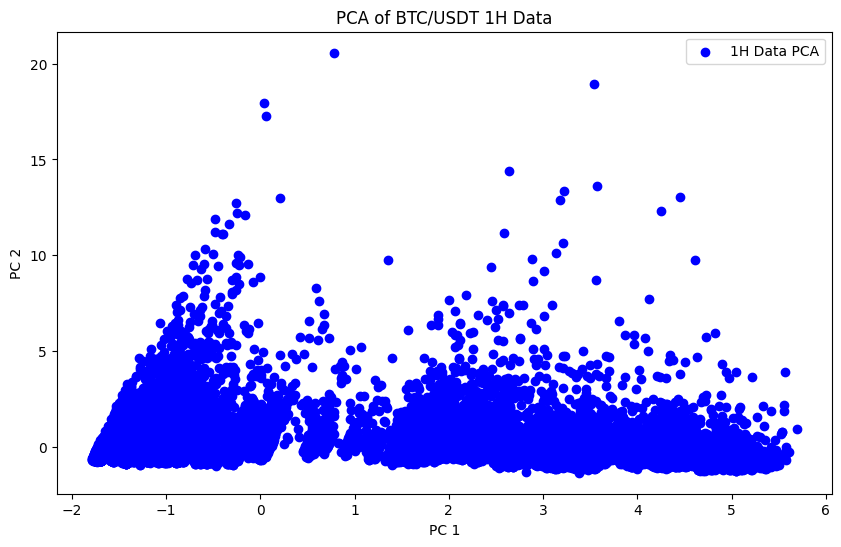

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Function to load data from CSV
def load_data(file_path):
    return pd.read_csv(file_path)

# Load all time frame datasets
data_1h = load_data(os.path.join(folder_path, 'btcusdt_1h.csv'))
data_3m = load_data(os.path.join(folder_path, 'btcusdt_3m.csv'))
data_5m = load_data(os.path.join(folder_path, 'btcusdt_5m.csv'))
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))
data_30m = load_data(os.path.join(folder_path, 'btcusdt_30m.csv'))

# Example to check if data is loaded correctly
print("1H Data Head: \n", data_1h.head())
print("3M Data Head: \n", data_3m.head())

# Example of preprocessing (e.g., handling missing data, scaling)
def preprocess_data(df):
    # Handle missing values (forward fill)
    df.fillna(method='ffill', inplace=True)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.select_dtypes(include=[np.number]))

    return pd.DataFrame(scaled_data, columns=df.select_dtypes(include=[np.number]).columns)

# Preprocess all datasets
data_1h_preprocessed = preprocess_data(data_1h)
data_3m_preprocessed = preprocess_data(data_3m)
data_5m_preprocessed = preprocess_data(data_5m)
data_15m_preprocessed = preprocess_data(data_15m)
data_30m_preprocessed = preprocess_data(data_30m)

# Principal Component Analysis (PCA) example
def apply_pca(df, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(df)
    return pca_result

# Apply PCA to 1H data as an example
pca_1h = apply_pca(data_1h_preprocessed)
print("PCA Result (1H): \n", pca_1h[:5])

# Visualization of PCA (Example for 1H data)
plt.figure(figsize=(10, 6))
plt.scatter(pca_1h[:, 0], pca_1h[:, 1], c='blue', label='1H Data PCA')
plt.title('PCA of BTC/USDT 1H Data')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()



In [2]:
!pip install pandas_ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=2b13cb29587b9caf75b8a094819520cfb279505becfe06e257c872919cd02437
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [5]:
import datetime
import pandas_ta as ta
import pandas as pd

from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [4]:
!pip3 install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173912 sha256=ff0bfb3b7edd8c39f7838cbb862235e7321a5fe0aee10078cbeaa9217d98c4ee
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[*********************100%***********************]  1 of 1 completed
<ipython-input-6-b269d7ffb136>:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_yf['Position'].fillna(0, inplace=True)  # Fill NaN with 0 for the first day


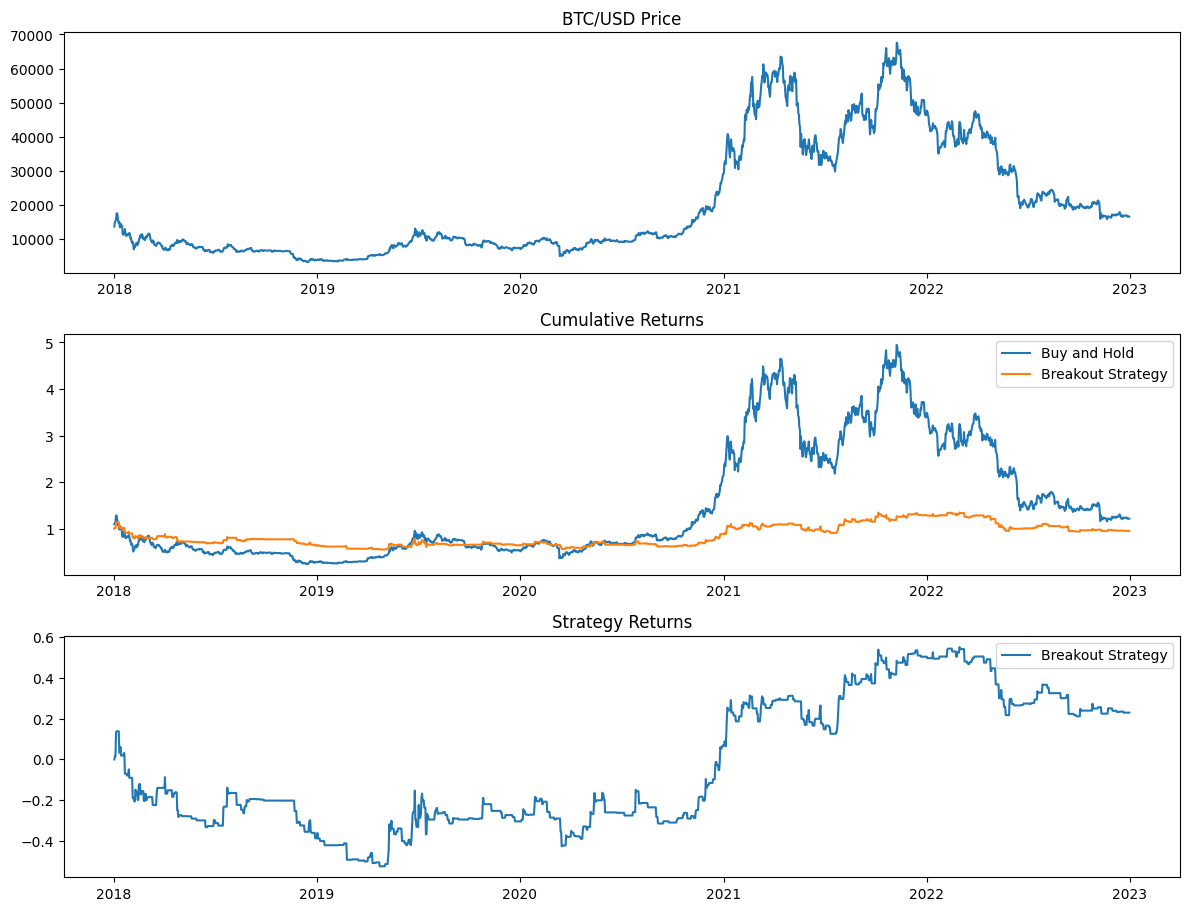

Sharpe Ratio: 0.1140


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for '

Start                     2018-01-01 00:00:00
End                       2022-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                   27.108434
Equity Final [$]                          0.0
Equity Peak [$]                 362501.054909
Return [%]                             -100.0
Buy & Hold Return [%]               21.163166
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              211.297294
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -13.897598
Max. Drawdown Duration     1477 days 00:00:00
Avg. Drawdown Duration       83 days 00:00:00
# Trades                                    7
Win Rate [%]                        57.142857
Best Trade [%]                      51.814431
Worst Trade [%]                    -93.618816
Avg. Trade [%]                    

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest

# Set folder path to your Google Drive folder
folder_path = '/content/drive/MyDrive/Quant Guild/mid_zelta/data/'

# Function to load data from CSV
def load_data(file_path):
    return pd.read_csv(file_path)

# Load all time frame datasets from Google Drive
data_1h = load_data(os.path.join(folder_path, 'btcusdt_1h.csv'))
data_3m = load_data(os.path.join(folder_path, 'btcusdt_3m.csv'))
data_5m = load_data(os.path.join(folder_path, 'btcusdt_5m.csv'))
data_15m = load_data(os.path.join(folder_path, 'btcusdt_15m.csv'))
data_30m = load_data(os.path.join(folder_path, 'btcusdt_30m.csv'))

# BTC-USD data from yfinance for breakout strategy
symbol = "BTC-USD"
start_date = "2018-01-01"
end_date = "2023-01-01"
data_yf = yf.download(symbol, start=start_date, end=end_date)

# Breakout Strategy
breakout_threshold = 0.02  # 2% breakout threshold
data_yf['PreviousClose'] = data_yf['Close'].shift(1)
data_yf['LongSignal'] = 0
data_yf.loc[data_yf['Close'] > (1 + breakout_threshold) * data_yf['PreviousClose'], 'LongSignal'] = 1

data_yf['Position'] = data_yf['LongSignal'].shift(1)  # Enter the position on the next day
data_yf['Position'].fillna(0, inplace=True)  # Fill NaN with 0 for the first day
data_yf['DailyReturns'] = data_yf['Close'].pct_change()
data_yf['StrategyReturns'] = data_yf['Position'] * data_yf['DailyReturns']
data_yf['CumulativeReturns'] = (1 + data_yf['DailyReturns']).cumprod()
data_yf['CumulativeStrategyReturns'] = (1 + data_yf['StrategyReturns']).cumprod()

# Calculate Sharpe Ratio for the breakout strategy
average_strategy_return = data_yf['StrategyReturns'].mean()
std_dev_strategy_return = data_yf['StrategyReturns'].std()
sharpe_ratio = np.sqrt(252) * average_strategy_return / std_dev_strategy_return

# Plot Breakout Strategy Results
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(data_yf['Close'], label='BTC/USD')
plt.title('BTC/USD Price')

plt.subplot(4, 1, 2)
plt.plot(data_yf['CumulativeReturns'], label='Buy and Hold')
plt.plot(data_yf['CumulativeStrategyReturns'], label='Breakout Strategy')
plt.legend()
plt.title('Cumulative Returns')

plt.subplot(4, 1, 3)
plt.plot(data_yf['StrategyReturns'].cumsum(), label='Breakout Strategy')
plt.legend()
plt.title('Strategy Returns')

plt.tight_layout()
plt.show()

print(f'Sharpe Ratio: {sharpe_ratio:.4f}')

# Define Exponential Moving Average (EMA) function
def EMA_Backtesting(values, n):
    """
    Return exponential moving average of `values`, at
    each step taking into account `n` previous values.
    """
    close = pd.Series(values)
    return close.ewm(span=n, adjust=False).mean()

# Define EMA Crossover Strategy for Backtesting
class EmaCrossStrategy(Strategy):
    n1 = 12  # Fast EMA
    n2 = 26  # Slow EMA
    n3 = 7   # Additional EMA for exit condition

    def init(self):
        self.ema12 = self.I(EMA_Backtesting, self.data.Close, self.n1)
        self.ema26 = self.I(EMA_Backtesting, self.data.Close, self.n2)
        self.ema7 = self.I(EMA_Backtesting, self.data.Close, self.n3)

    def next(self):
        if crossover(self.ema12, self.ema26) and self.data.Close < self.ema7:
            self.buy()
        elif self.data.Close > self.ema7:
            self.sell()

# Apply EMA Cross Strategy Backtest on the 1H dataset from yfinance (or any custom timeframe)
bt = Backtest(data_yf, EmaCrossStrategy, cash=100000, commission=0.002, trade_on_close=True)
stats = bt.run()
bt.plot()
print(stats)


In [7]:
# Apply EMA Cross Strategy Backtest on the BTC-USD dataset
bt = Backtest(data_yf, EmaCrossStrategy, cash=100000, commission=0.002, trade_on_close=True)
stats = bt.run()

# Plot the backtest results
bt.plot()

# Print initial and final portfolio value
initial_portfolio_value = stats['Start Cash']
final_portfolio_value = stats['Equity Final [$]']

print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")


/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = (df.assign(_width=1).set_index('datetime')
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for '

KeyError: 'Start Cash'

In [8]:
# Run the EMA Cross Strategy Backtest on the BTC-USD dataset
bt = Backtest(data_yf, EmaCrossStrategy, cash=100000, commission=0.002, trade_on_close=True)
stats = bt.run()

# Inspect the stats keys and values
print(stats)

# Correctly reference the available keys for initial and final portfolio values
initial_portfolio_value = stats['_equity_curve']['Equity'][0]  # First value in the equity curve is the initial portfolio value
final_portfolio_value = stats['_equity_curve']['Equity'].iloc[-1]  # Last value is the final portfolio value

# Print initial and final portfolio values
print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

# Plot the backtest results
bt.plot()

# Suppress Bokeh warnings related to deprecated formatting
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="backtesting._plotting")
warnings.filterwarnings("ignore", category=FutureWarning)


Start                     2018-01-01 00:00:00
End                       2022-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                   27.108434
Equity Final [$]                          0.0
Equity Peak [$]                 362501.054909
Return [%]                             -100.0
Buy & Hold Return [%]               21.163166
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              211.297294
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                  -13.897598
Max. Drawdown Duration     1477 days 00:00:00
Avg. Drawdown Duration       83 days 00:00:00
# Trades                                    7
Win Rate [%]                        57.142857
Best Trade [%]                      51.814431
Worst Trade [%]                    -93.618816
Avg. Trade [%]                    

<ipython-input-8-7a71c423c629>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_portfolio_value = stats['_equity_curve']['Equity'][0]  # First value in the equity curve is the initial portfolio value
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future v